# Basic DNN

This is a simple attempt using a basic DNN. This will be used as a pre-trained model for my inference kernel. Some of the hyperparameters and choices are derived from my [EDA kernel](https://www.kaggle.com/yzgast/jsmp-basic-eda-starter). 

In [1]:
import gc
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from tensorflow import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

random.set_seed(5577)

## Data Loading

In [2]:
trainDf = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv')

## Data Preparation

**Train / target split**

In [3]:
trainDf = trainDf[trainDf["weight"] > 0]
trainDf.fillna(0, inplace=True)

dropCols = ["resp", "resp_1", "resp_2", "resp_3", "resp_4", "ts_id"]
dfTrain = trainDf.drop(columns=dropCols).values.astype(np.float32)
targets = (trainDf["resp"] > 0).astype(np.int).values

**PCA**

In [4]:
scaler = MinMaxScaler()
scaledTrain = scaler.fit_transform(dfTrain)

pca = PCA(n_components=11)
pca.fit(scaledTrain)

pickledPCA = open("pcaFit.pkl", 'wb')
pickle.dump(pca, pickledPCA)
pickledPCA.close()

sTrainFeatures = pca.transform(scaledTrain)
print(sTrainFeatures.shape)
featuresCount = sTrainFeatures.shape[1]

(1981287, 11)


## Cleaning variables

In [5]:
del dfTrain
del pca
del scaledTrain
gc.collect()

62

## Hyperparameters

In [6]:
nSplits = 5
batchSize = 50000
epochCount = 128
hiddenLayerSize = 1024
dropOut = 0.2

## Model Creation

In [7]:
def getModel(hiddenLayerSize=1024, dropOut=0.2):
	model = Sequential()
	model.add(Dense(hiddenLayerSize, input_dim=featuresCount, activation='relu'))
	model.add(Dropout(dropOut))
	model.add(Dense(hiddenLayerSize,activation='relu'))
	model.add(Dropout(dropOut))
	model.add(Dense(hiddenLayerSize,activation='relu'))
	model.add(Dropout(dropOut))
	model.add(Dense(1, activation="sigmoid"))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
	return model


## Fitting the model

In [8]:
models = []
history = {}
verbosity = 1

kfold = KFold(n_splits=nSplits, shuffle=True)
for j, (train_idx, val_idx) in enumerate(kfold.split(sTrainFeatures)):
	model = getModel(hiddenLayerSize, dropOut)
	history[j] = model.fit(sTrainFeatures[train_idx], targets[train_idx], validation_data=(sTrainFeatures[val_idx], targets[val_idx]), batch_size=batchSize, epochs=epochCount, verbose=verbosity)
	scores = model.evaluate(sTrainFeatures[val_idx], targets[val_idx], verbose=verbosity)
	print('Fold %d: %s of %f' % (j,model.metrics_names[0],scores[0]))
	print('Fold %d: %s of %f' % (j,model.metrics_names[1],scores[1]))
	models.append(model)


Epoch 1/128
32/32 [==============================] - 4s 123ms/step - loss: 0.6921 - accuracy: 0.5159 - val_loss: 0.6914 - val_accuracy: 0.5200
Epoch 2/128
32/32 [==============================] - 4s 120ms/step - loss: 0.6915 - accuracy: 0.5200 - val_loss: 0.6911 - val_accuracy: 0.5214
Epoch 3/128
32/32 [==============================] - 4s 119ms/step - loss: 0.6911 - accuracy: 0.5222 - val_loss: 0.6908 - val_accuracy: 0.5228
Epoch 4/128
32/32 [==============================] - 4s 122ms/step - loss: 0.6907 - accuracy: 0.5234 - val_loss: 0.6903 - val_accuracy: 0.5243
Epoch 5/128
32/32 [==============================] - 4s 120ms/step - loss: 0.6903 - accuracy: 0.5247 - val_loss: 0.6899 - val_accuracy: 0.5261
Epoch 6/128
32/32 [==============================] - 4s 118ms/step - loss: 0.6899 - accuracy: 0.5261 - val_loss: 0.6895 - val_accuracy: 0.5268
Epoch 7/128
32/32 [==============================] - 4s 120ms/step - loss: 0.6894 - accuracy: 0.5278 - val_loss: 0.6889 - val_accuracy: 0.5289

## Plotting accuracy & loss

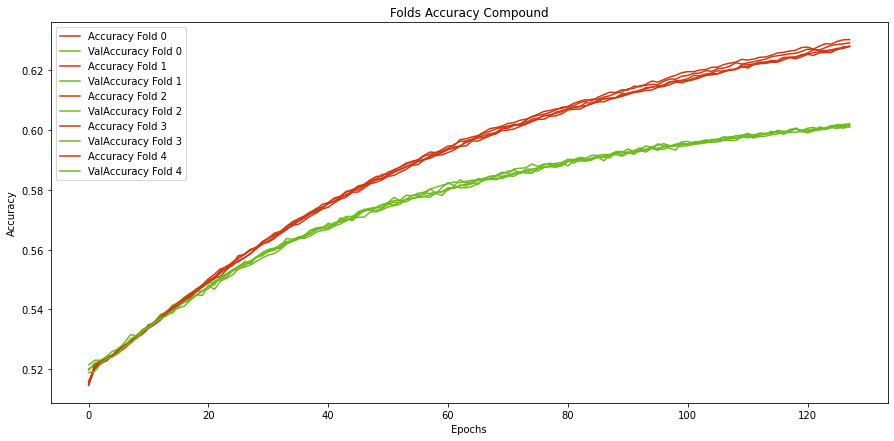

In [9]:
plt.figure(figsize=(15,7))
for k,v in history.items():
	plt.plot(v.history["accuracy"], color='#d13812', label="Accuracy Fold "+str(k))
	plt.plot(v.history["val_accuracy"], color='#6dbc1e', label="ValAccuracy Fold "+str(k))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Folds Accuracy Compound')
plt.legend()
plt.show()

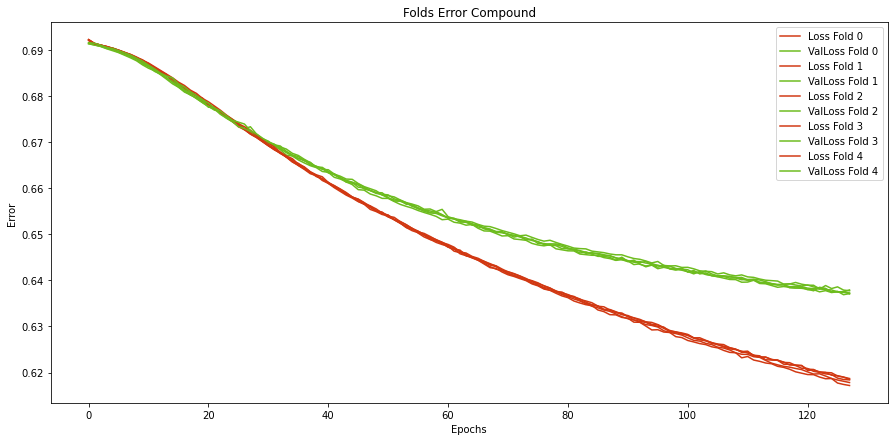

In [10]:
plt.figure(figsize=(15,7))
for k,v in history.items():
	plt.plot(v.history["loss"], color='#d13812', label="Loss Fold "+str(k))
	plt.plot(v.history["val_loss"], color='#6dbc1e', label="ValLoss Fold "+str(k))

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Folds Error Compound')
plt.legend()
plt.show()

## Saving the model

In [11]:
model.save("model.h5")